In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import kagglehub
import io
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [3]:


import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
# from torch import datasets, transforms
import matplotlib.pyplot as plt

np.random.seed(42)

data_path = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"

data = pd.read_csv(data_path)

# Separate features and labels
labels = data.iloc[:, 0].values  # First column is the label
images = data.iloc[:, 1:].values  # Remaining columns are pixel values

# Reshape images to 28x28
images = images.reshape(-1, 28, 28).astype(np.float32)
images = images / 255.0

# Split the dataset
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.6667, random_state=42)  # 10% for val, 20% for test

0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot

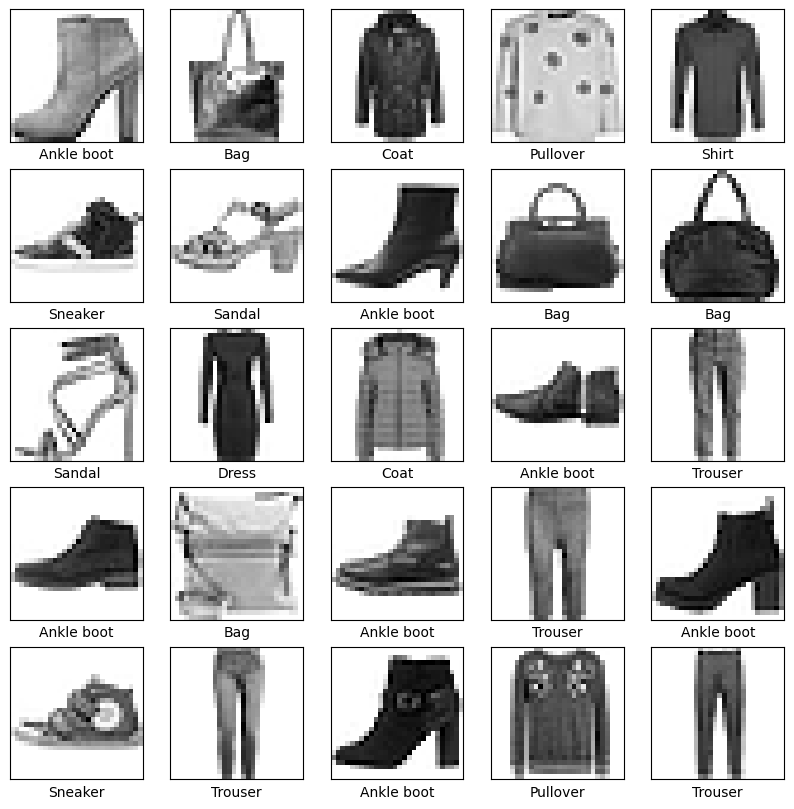

In [4]:
# Class names based on Fashion MNIST (can be left blank initially and guessed)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot a few images with labels
plt.figure(figsize=(10, 10))
for i in range(25):  # Display 25 images as an example
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [4]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        # Convert image to tensor and add a channel dimension
        image = torch.tensor(image).unsqueeze(0)  # Shape: (1, 28, 28)
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

# Create dataset instances for train, val, and test sets
train_dataset = FashionMNISTDataset(train_images, train_labels)
val_dataset = FashionMNISTDataset(val_images, val_labels)
test_dataset = FashionMNISTDataset(test_images, test_labels)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CnnAutoencoder(nn.Module):
    def __init__(self, latent_dim=64, kernel=3, filters=[32, 64, 128], input_size=(1, 28, 28)):
        super(CnnAutoencoder, self).__init__()
        
        self.filters = filters
        self.kernel = kernel
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(filters[0], filters[1], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(filters[1], filters[2], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.flatten = nn.Flatten()
        self.flattened_size = self._get_flattened_size()
        self.fc_latent = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder: Upsampling to reconstruct the image
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)  # Fully connected to expand latent vector
        # self.decoder_conv1 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv2 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv3 = nn.ConvTranspose2d(filters[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(filters[2], filters[1], kernel_size=kernel, stride=3, padding=(kernel // 2) + 1, output_padding=2),  # 3x3 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(filters[1], filters[0], kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(filters[0], 1, kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output values in range [0, 1]
        )
    
    def _get_flattened_size(self):
        # Pass a dummy tensor through the encoder to determine the output size
        with torch.no_grad():
            dummy_input = torch.zeros(self.input_size)  # Create a dummy input
            x = self.encoder(dummy_input.unsqueeze(0))  # Add batch dimension
            return x.numel()  # Return the number of elements in the output tensor
        
    def encode(self, x):
        # Pass through the encoder and then flatten to get the latent representation
        x = self.encoder(x)
        x = self.flatten(x)
        latent = self.fc_latent(x)
        return latent

    def decode(self, latent):
        # Expand the latent vector and reshape it to pass through the decoder
        x = self.fc_decode(latent)
        x = x.view(-1, self.filters[2], 3, 3)  # Reshape to match the decoder input size
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x):
        # Perform the forward pass by calling encode and decode
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed
    
    def train_autoencoder(self, train_loader, val_loader=None, num_epochs=10, learning_rate=0.001, optimizer_choice='adam'):
        if optimizer_choice == 'adam':
            optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        elif optimizer_choice == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.5)
        else:
            raise ValueError("Optimizer choice should be 'adam' or 'sgd'")
        
        criterion = nn.MSELoss() # Using MSE loss for reconstruction
        
        train_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            
            for images, _ in train_loader:
                images = images.to(next(self.parameters()).device)
                optimizer.zero_grad()
                
                # Forward Pass
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                
                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)
                
            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")
            train_loss.append(avg_loss)
            if val_loader:
                val_loss = self.validate_autoencoder(val_loader, criterion)
                print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}")
                validation_loss.append(val_loss)
        
        return train_loss, validation_loss
    
    def validate_autoencoder(self, val_loader, criterion):
        self.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(next(self.parameters()).device)
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                val_loss = loss.item() * images.size(0)
                
        avg_val_loss = val_loss / len(val_loader.dataset)
        return avg_val_loss

In [8]:
# from models.AutoEncoders.cnn_autoencoder import CnnAutoencoder
latent_dim = 64
kernel_sizes = 3
filters = [32, 64, 128]

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = CnnAutoencoder(latent_dim=latent_dim, kernel=kernel_sizes, filters=filters).to(device)

learning_rate = 0.01
optimizer_choice = 'adam'

model.train_autoencoder(train_loader=train_loader, val_loader=val_loader, num_epochs=10, learning_rate=learning_rate, optimizer_choice=optimizer_choice)

Epoch [1/10], Train Loss: 0.0263
Epoch [1/10], Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0145
Epoch [2/10], Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0127
Epoch [3/10], Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0118
Epoch [4/10], Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0113
Epoch [5/10], Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0108
Epoch [6/10], Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0105
Epoch [7/10], Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0101
Epoch [8/10], Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0100
Epoch [9/10], Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0098
Epoch [10/10], Val Loss: 0.0001


([0.02630824303059351,
  0.014529040014459973,
  0.012730791690094131,
  0.011761072240769863,
  0.011255238098048029,
  0.010812543259135315,
  0.010453680357762745,
  0.010130788344002906,
  0.010007808047391119,
  0.009753686590918473],
 [0.0001288051765885904,
  0.00010845955656253014,
  0.00010010607122684404,
  0.00010081939911555202,
  9.066117860676149e-05,
  8.603983365743235e-05,
  8.290408622857868e-05,
  8.173507255903978e-05,
  7.92888078076638e-05,
  8.223119596552504e-05])

In [7]:
def visualize_reconstructions(model, test_loader, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        
        # Move images to the same device as the model
        device = next(model.parameters()).device
        images = images.to(device)

        # Pass the images through the autoencoder
        reconstructed = model(images)

        # Set up the plot
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Original images
            plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')  # Correct usage
            plt.title("Original")
            plt.axis('off')

            # Reconstructed images
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].cpu().numpy().squeeze(), cmap='gray')  # Correct usage
            plt.title("Reconstructed")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
def collect_latent_representations(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    latents = []
    labels = []
    
    # Get the device of the model
    device = next(model.parameters()).device

    with torch.no_grad():
        for images, batch_labels in data_loader:
            # Move images to the same device as the model
            images = images.to(device)  # Ensure images are on the same device
            latent = model.encode(images)  # Use the encode method from your model
            latents.append(latent.cpu().numpy())  # Store the latent representations
            labels.append(batch_labels.cpu().numpy())  # Store the labels
    
    latents = np.concatenate(latents)  # Concatenate all latents
    labels = np.concatenate(labels)  # Concatenate all labels
    
    return latents, labels


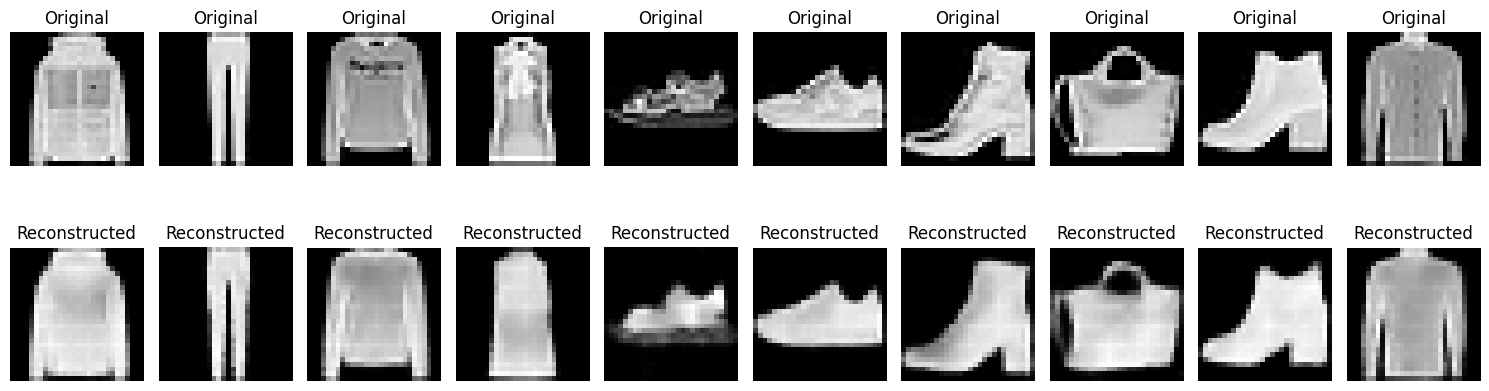

In [13]:

visualize_reconstructions(model, test_loader, num_images=10)


*Analysis:*

- *Cluster Formation*: We can see distinct clusters in the plot, suggesting that the autoencoder has learned some separation between different classes. Items like shoes, bags, and clothing have likely formed their own groupings. The 3D plot allows for even better separation, indicating that the third component may capture additional variance helpful in distinguishing these items.
- *Overlapping Classes*: Some clusters show overlap, which could indicate that certain classes, such as "T-shirt/top" and "Shirt," share similar features in the latent space. This is expected, as these categories may have similar structural characteristics, making them harder to differentiate fully.
- *Compactness of Clusters*: Certain clusters appear more compact, suggesting that the features extracted for these classes are more distinct and consistent. This compactness may imply that the autoencoder effectively captures and compresses the defining features for these items.
- *Spread of Latent Representations*: There is a visible spread in the latent space, especially along the primary PCA component, which may represent a general gradient from clothing to accessories like shoes or bags.

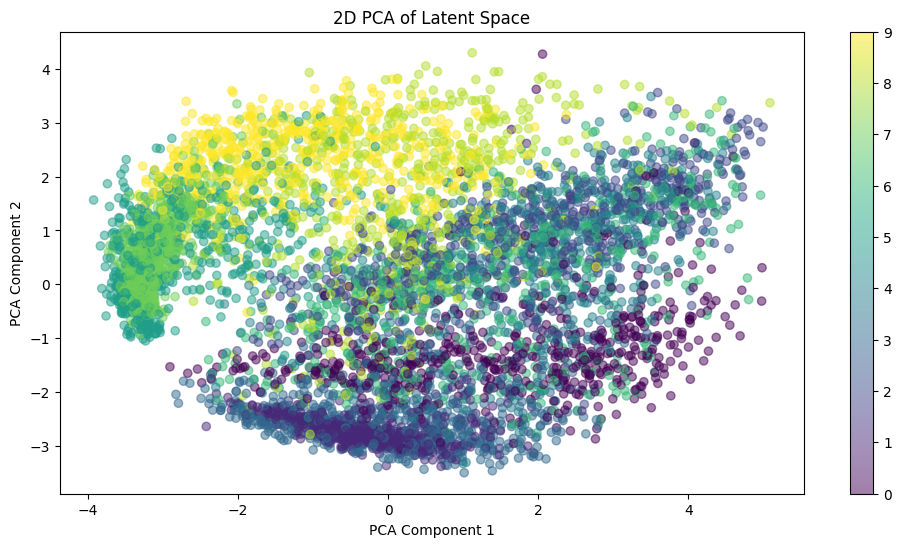

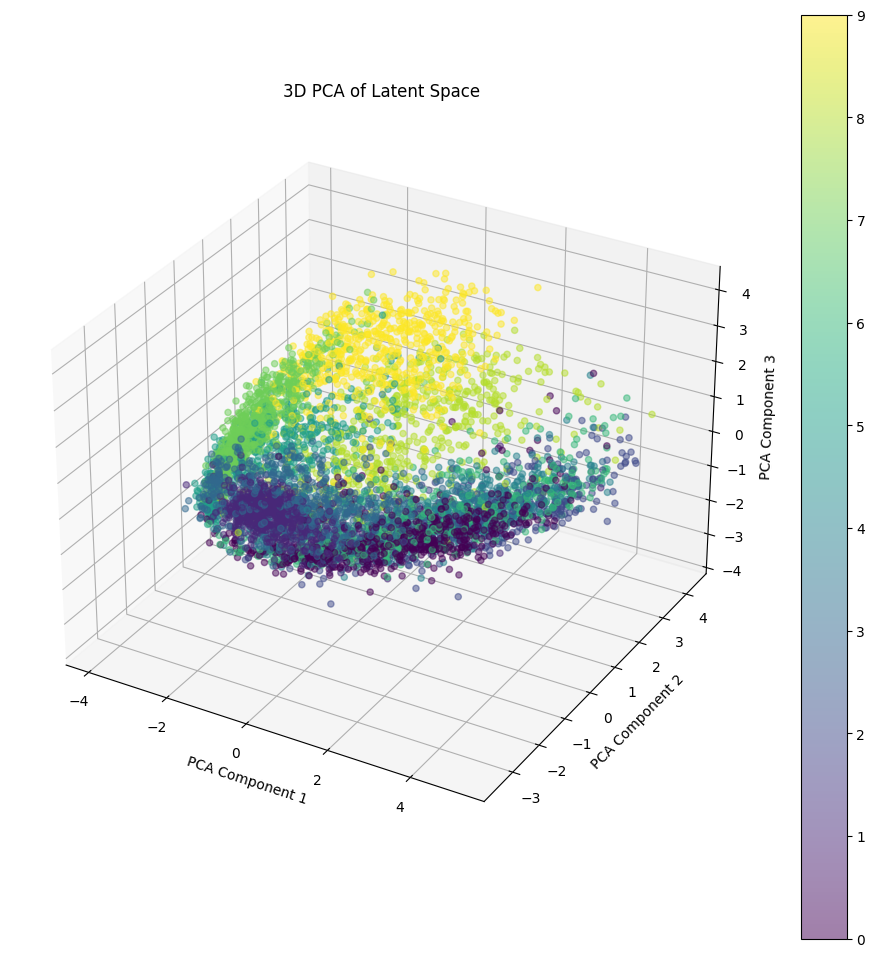

In [9]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import wandb

def plot_latent_space(latents, labels):
    # 2D PCA
    pca_2d = PCA(n_components=2)
    latents_2d = pca_2d.fit_transform(latents)

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('2D PCA of Latent Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    # 3D PCA
    pca_3d = PCA(n_components=3)
    latents_3d = pca_3d.fit_transform(latents)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents_3d[:, 0], latents_3d[:, 1], latents_3d[:, 2], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    ax.set_title('3D PCA of Latent Space')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    plt.show()
    
# Assuming you have a trained model and a validation/test data loader
latents, labels = collect_latent_representations(model, val_loader)

# Plot the latent space
plot_latent_space(latents, labels)


2D Analysis:

    Cluster Formation: The plot reveals distinct clusters, indicating the autoencoder effectively separates different classes, such as shoes, bags, and clothing.
    Overlapping Classes: Some clusters overlap, especially between "T-shirt/top" and "Shirt," reflecting their similar features and structural characteristics.
    Compactness of Clusters: Classes like "Ankle boot" and "Bag" are more compact, suggesting the autoencoder successfully captures and distinguishes their defining features.
    Spread of Latent Representations: A notable spread along the primary PCA component indicates a gradient from clothing to accessories, such as shoes and bags.

3D Analysis:

    Improved Class Separation: The 3D visualization enhances class separation, especially for categories like "Bag" and "Ankle boot," capturing additional variance.
    Inter-Class Proximity: Similar clothing items still show overlap, but the third component improves separation without fully distinguishing them.
    Compact Clusters for Accessories: Accessories like "Sandal" and "Bag" are well-separated and compact, highlighting their distinct visual features.

Observations

    Clothing items form a continuous, overlapping region in latent space, while footwear items create more distinct clusters.
    The "Bag" category has a tightly defined cluster, isolated from clothing and footwear, due to its unique shape and features.
    "Shirt," "Pullover," and "T-shirt/top" show significant overlap, indicating shared visual attributes, such as fabric and shape.
    "Dress" and "Coat" also overlap with other clothing items, suggesting difficulty in distinction by the network.
    "Sneaker" and "Sandal" clusters are closer together than to "Ankle boot," which is more isolated due to its taller silhouette. This indicates the autoencoder effectively recognizes features like ankle coverage.
    Interestingly, "Sandal" and "Bag" clusters are relatively close, indicating the network has detected common features like open structures in both categories.

In [6]:
import wandb

def hyperparameter_tuning_sweep_autoencoder(train_loader, val_loader, device='cpu'):
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_loss',  # You may choose 'val_mse' or any other relevant metric
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'values': [0.001, 0.01]
            },
            'kernel': {
                'values': [5, 7]
            },
            'optimizer': {
                'values': ['adam', 'sgd']
            },
            'filters': {
                'values': [[32, 64, 128], [8, 16, 32]]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="CNN-Autoencoder-Hyperparameter-Tuning")

    def train_and_evaluate():
        wandb.init()
        config = wandb.config
        print(f"Running with config: {config}")
        wandb.run.name = f"filters={config['filters']}-optimizer={config['optimizer']}-lr={config['learning_rate']}-kernel={config['kernel']}"

        model = CnnAutoencoder(kernel=config['kernel'], filters=config['filters']).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate']) if config['optimizer'] == 'adam' else optim.SGD(model.parameters(), lr=config['learning_rate'])

        criterion = nn.MSELoss()  # Using MSE loss for reconstruction

        train_losses, val_losses = [], []

        for epoch in range(10):
            model.train()
            running_loss = 0.0

            for images, _ in train_loader:
                images = images.to(device)
                optimizer.zero_grad()

                # Forward Pass
                reconstructed = model(images)
                loss = criterion(reconstructed, images)

                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)

            avg_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_loss)

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, _ in val_loader:
                    images = images.to(device)
                    reconstructed = model(images)
                    loss = criterion(reconstructed, images)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_loss,
                "val_loss": avg_val_loss
            })

        wandb.finish()

    wandb.agent(sweep_id, function=train_and_evaluate)
hyperparameter_tuning_sweep_autoencoder(train_loader, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: ni24nvgi
Sweep URL: https://wandb.ai/vcnk4v/CNN-Autoencoder-Hyperparameter-Tuning/sweeps/ni24nvgi


wandb: Agent Starting Run: jpjj3qox with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: vcnk4v. Use `wandb login --relogin` to force relogin


Running with config: {'filters': [32, 64, 128], 'kernel': 5, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_loss,0.00697
val_loss,0.00727


wandb: Agent Starting Run: b9ypls4g with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'filters': [32, 64, 128], 'kernel': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_loss,0.13205
val_loss,0.13169


wandb: Agent Starting Run: rgza0qh2 with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Running with config: {'filters': [32, 64, 128], 'kernel': 5, 'learning_rate': 0.01, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▅▃▃▄▃▂▂▁▁
epoch,10
train_loss,0.0112
val_loss,0.01113


wandb: Agent Starting Run: 36gbbkbn with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


Running with config: {'filters': [32, 64, 128], 'kernel': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_loss,0.12445
val_loss,0.12466


wandb: Agent Starting Run: qknd87xd with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'filters': [32, 64, 128], 'kernel': 7, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_loss,0.00692
val_loss,0.0072


wandb: Agent Starting Run: 6s8qmcxp with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'filters': [32, 64, 128], 'kernel': 7, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_loss,0.13184
val_loss,0.13151


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 57peobk7 with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Running with config: {'filters': [32, 64, 128], 'kernel': 7, 'learning_rate': 0.01, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▅▇▃▂▃▂▂▁▂
epoch,10
train_loss,0.01388
val_loss,0.0148


wandb: Agent Starting Run: 6yv56lr4 with config:
wandb: 	filters: [32, 64, 128]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


Running with config: {'filters': [32, 64, 128], 'kernel': 7, 'learning_rate': 0.01, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_loss,0.12439
val_loss,0.12454


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v32o17ci with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'filters': [8, 16, 32], 'kernel': 5, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_loss,0.01141
val_loss,0.01152


wandb: Agent Starting Run: 8jlf8842 with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'filters': [8, 16, 32], 'kernel': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▅▄▃▃▂▂▁▁
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,10
train_loss,0.13488
val_loss,0.1343


wandb: Agent Starting Run: svhnh7qy with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Running with config: {'filters': [8, 16, 32], 'kernel': 5, 'learning_rate': 0.01, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_loss,█▅▅▃▃▃▂▂▁▁
epoch,10
train_loss,0.01079
val_loss,0.01087


wandb: Agent Starting Run: yqm91fyf with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


Running with config: {'filters': [8, 16, 32], 'kernel': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_loss,0.12474
val_loss,0.12493


wandb: Agent Starting Run: 5gjqsotu with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Running with config: {'filters': [8, 16, 32], 'kernel': 7, 'learning_rate': 0.001, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_loss,█▅▄▄▃▂▂▁▁▁
epoch,10
train_loss,0.0113
val_loss,0.01125


wandb: Agent Starting Run: y3omnowj with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Running with config: {'filters': [8, 16, 32], 'kernel': 7, 'learning_rate': 0.001, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▅▄▄▃▂▂▁▁
val_loss,█▇▅▄▄▃▂▂▁▁
epoch,10
train_loss,0.13397
val_loss,0.13349


wandb: Agent Starting Run: nfw050pb with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Running with config: {'filters': [8, 16, 32], 'kernel': 7, 'learning_rate': 0.01, 'optimizer': 'adam'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▅▅▂▅▁▁▁▁▂
epoch,10
train_loss,0.01228
val_loss,0.01367


wandb: Agent Starting Run: szotmjjb with config:
wandb: 	filters: [8, 16, 32]
wandb: 	kernel: 7
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


Running with config: {'filters': [8, 16, 32], 'kernel': 7, 'learning_rate': 0.01, 'optimizer': 'sgd'}


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_loss,0.12465
val_loss,0.12486


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [7]:
best_model_parameters = {
    'filters': [32, 64, 128],
    'kernel_size': 7,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'num_epochs': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_autoencoder = CnnAutoencoder(latent_dim=64, kernel=best_model_parameters['kernel_size'], filters=best_model_parameters['filters']).to(device)

cnn_autoencoder.train_autoencoder(train_loader, val_loader, num_epochs=best_model_parameters['num_epochs'], learning_rate=best_model_parameters['learning_rate'], optimizer_choice=best_model_parameters['optimizer'])

Epoch [1/10], Train Loss: 0.0263
Epoch [1/10], Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0131
Epoch [2/10], Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0108
Epoch [3/10], Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0096
Epoch [4/10], Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0088
Epoch [5/10], Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0082
Epoch [6/10], Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0077
Epoch [7/10], Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0074
Epoch [8/10], Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0071
Epoch [9/10], Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0069
Epoch [10/10], Val Loss: 0.0001


([0.02630660147290854,
  0.013079200023696537,
  0.010765386406509649,
  0.009570226971947012,
  0.008754570647364571,
  0.008183717328168097,
  0.007741416497067327,
  0.007386843788836683,
  0.0071355491814514005,
  0.006883769964355798],
 [0.00012655584643057614,
  9.543527738017467e-05,
  8.288275103958314e-05,
  7.744958901513634e-05,
  6.941689765489108e-05,
  6.491471309252711e-05,
  6.30220760651719e-05,
  6.284035483332033e-05,
  6.0853770738279725e-05,
  5.925696245067854e-05])

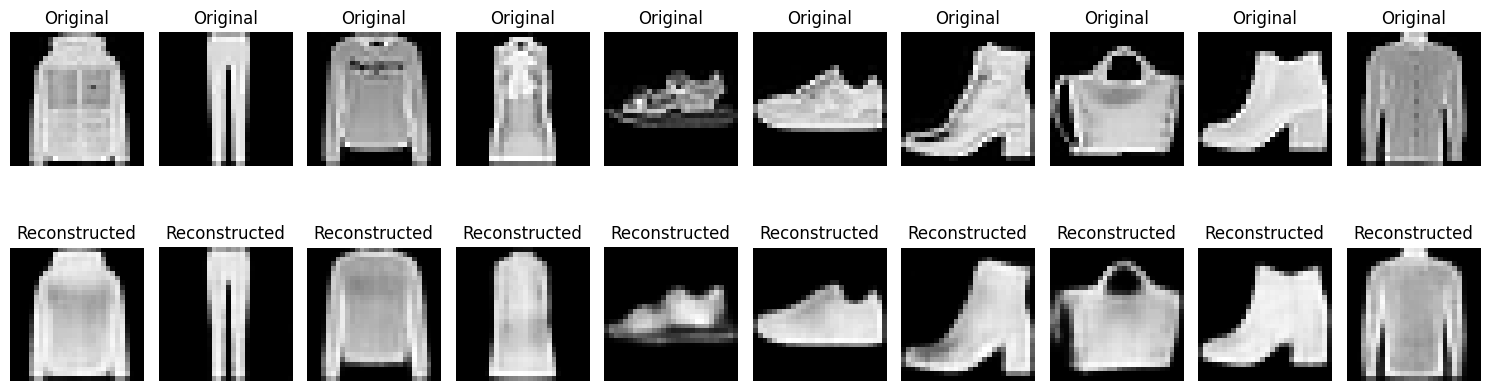

Train Reconstruction Error: 0.007374
Validation Reconstruction Error: 0.008781
Test Reconstruction Error: 0.006541


In [10]:
visualize_reconstructions(cnn_autoencoder, test_loader, num_images=10)

images, _ = next(iter(train_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
train_reconstruction_error = ((images - reconstructed) ** 2).mean().item()
images, _ = next(iter(val_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
val_reconstruction_error = ((images - reconstructed) ** 2).mean().item()
images, _ = next(iter(test_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
test_reconstruction_error = ((images - reconstructed) ** 2).mean().item()

print(f"Train Reconstruction Error: {train_reconstruction_error:.6f}")
print(f"Validation Reconstruction Error: {val_reconstruction_error:.6f}")
print(f"Test Reconstruction Error: {test_reconstruction_error:.6f}")

In [9]:
class CnnAutoencoder_two_layers(nn.Module):
    def __init__(self, latent_dim=64, kernel=3, filters=[32, 64], input_size=(1, 28, 28)):
        super(CnnAutoencoder_two_layers, self).__init__()
        
        self.filters = filters
        self.kernel = kernel
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(filters[0], filters[1], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
#             nn.Conv2d(filters[1], filters[2], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 7x7 -> 7x7
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)  # 7x7 -> 3x3
        )
        
        self.flatten = nn.Flatten()
        self.flattened_size = self._get_flattened_size()
        self.fc_latent = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder: Upsampling to reconstruct the image
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)  # Fully connected to expand latent vector
        # self.decoder_conv1 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv2 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv3 = nn.ConvTranspose2d(filters[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(filters[2], filters[1], kernel_size=kernel, stride=3, padding=(kernel // 2) + 1, output_padding=2),  # 3x3 -> 7x7
#             nn.ReLU(),
            nn.ConvTranspose2d(filters[1], filters[0], kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(filters[0], 1, kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output values in range [0, 1]
        )
    
    def _get_flattened_size(self):
        # Pass a dummy tensor through the encoder to determine the output size
        with torch.no_grad():
            dummy_input = torch.zeros(self.input_size)  # Create a dummy input
            x = self.encoder(dummy_input.unsqueeze(0))  # Add batch dimension
            return x.numel()  # Return the number of elements in the output tensor
        
    def encode(self, x):
        # Pass through the encoder and then flatten to get the latent representation
        x = self.encoder(x)
        x = self.flatten(x)
        latent = self.fc_latent(x)
        return latent

    def decode(self, latent):
        # Expand the latent vector and reshape it to pass through the decoder
        x = self.fc_decode(latent)
        x = x.view(-1, self.filters[1], 7, 7)  # Reshape to match the decoder input size
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x):
        # Perform the forward pass by calling encode and decode
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed
    
    def train_autoencoder(self, train_loader, val_loader=None, num_epochs=10, learning_rate=0.001, optimizer_choice='adam'):
        if optimizer_choice == 'adam':
            optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        elif optimizer_choice == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.5)
        else:
            raise ValueError("Optimizer choice should be 'adam' or 'sgd'")
        
        criterion = nn.MSELoss() # Using MSE loss for reconstruction
        
        train_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            
            for images, _ in train_loader:
                images = images.to(next(self.parameters()).device)
                optimizer.zero_grad()
                
                # Forward Pass
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                
                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)
                
            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")
            train_loss.append(avg_loss)
            if val_loader:
                val_loss = self.validate_autoencoder(val_loader, criterion)
                print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}")
                validation_loss.append(val_loss)
        
        return train_loss, validation_loss
                
    def validate_autoencoder(self, val_loader, criterion):
        self.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(next(self.parameters()).device)
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                val_loss = loss.item() * images.size(0)
                
        avg_val_loss = val_loss / len(val_loader.dataset)
        return avg_val_loss
    
class CnnAutoencoder_one_layers(nn.Module):
    def __init__(self, latent_dim=64, kernel=3, filters=[32], input_size=(1, 28, 28)):
        super(CnnAutoencoder_one_layers, self).__init__()
        
        self.filters = filters
        self.kernel = kernel
        self.input_size = input_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
#             nn.Conv2d(filters[0], filters[1], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 14x14 -> 14x14
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
#             nn.Conv2d(filters[1], filters[2], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 7x7 -> 7x7
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),  # 7x7 -> 3x3
#             nn.Conv2d(filters[2], filters[3], kernel_size=kernel, stride=1, padding=(kernel // 2)),  # 3x3 -> 3x3
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)  # 1x1 -> 1x1
        )
        
        self.flatten = nn.Flatten()
        self.flattened_size = self._get_flattened_size()
        self.fc_latent = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder: Upsampling to reconstruct the image
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)  # Fully connected to expand latent vector
        # self.decoder_conv1 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv2 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.decoder_conv3 = nn.ConvTranspose2d(filters[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(filters[3], filters[2], kernel_size=kernel, stride=3, padding=(kernel // 2) + 1, output_padding=2),  # 1x1 -> 3x3
#             nn.ReLU(),
#             nn.ConvTranspose2d(filters[2], filters[1], kernel_size=kernel, stride=3, padding=(kernel // 2) + 1, output_padding=2),  # 3x3 -> 7x7
#             nn.ReLU(),
#             nn.ConvTranspose2d(filters[1], filters[0], kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 7x7 -> 14x14
#             nn.ReLU(),
            nn.ConvTranspose2d(filters[0], 1, kernel_size=kernel, stride=2, padding=(kernel // 2), output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output values in range [0, 1]
        )
    
    def _get_flattened_size(self):
        # Pass a dummy tensor through the encoder to determine the output size
        with torch.no_grad():
            dummy_input = torch.zeros(self.input_size)  # Create a dummy input
            x = self.encoder(dummy_input.unsqueeze(0))  # Add batch dimension
            return x.numel()  # Return the number of elements in the output tensor
        
    def encode(self, x):
        # Pass through the encoder and then flatten to get the latent representation
        x = self.encoder(x)
        x = self.flatten(x)
        latent = self.fc_latent(x)
        return latent

    def decode(self, latent):
        # Expand the latent vector and reshape it to pass through the decoder
        x = self.fc_decode(latent)
        x = x.view(-1, self.filters[0], 14, 14)  # Reshape to match the decoder input size
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x):
        # Perform the forward pass by calling encode and decode
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed
    
    def train_autoencoder(self, train_loader, val_loader=None, num_epochs=10, learning_rate=0.001, optimizer_choice='adam'):
        if optimizer_choice == 'adam':
            optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        elif optimizer_choice == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.5)
        else:
            raise ValueError("Optimizer choice should be 'adam' or 'sgd'")
        
        criterion = nn.MSELoss() # Using MSE loss for reconstruction
        
        train_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            
            for images, _ in train_loader:
                images = images.to(next(self.parameters()).device)
                optimizer.zero_grad()
                
                # Forward Pass
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                
                # Backward Pass and Optimization
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)
                
            avg_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")
            train_loss.append(avg_loss)
            if val_loader:
                val_loss = self.validate_autoencoder(val_loader, criterion)
                print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}")
                validation_loss.append(val_loss)
        
        return train_loss, validation_loss
                
    def validate_autoencoder(self, val_loader, criterion):
        self.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(next(self.parameters()).device)
                reconstructed = self(images)
                loss = criterion(reconstructed, images)
                val_loss = loss.item() * images.size(0)
                
        avg_val_loss = val_loss / len(val_loader.dataset)
        return avg_val_loss

In [17]:
model_1_layers = CnnAutoencoder_one_layers().to(device)
model_2_layers = CnnAutoencoder_two_layers().to(device)
model_3_layers = CnnAutoencoder().to(device)

# Assuming train_loader and val_loader are already defined
train_loss_1, val_loss_1 = model_1_layers.train_autoencoder(train_loader=train_loader, val_loader=val_loader)
train_loss_2, val_loss_2 = model_2_layers.train_autoencoder(train_loader=train_loader, val_loader=val_loader)
train_loss_3,val_loss_3 = model_3_layers.train_autoencoder(train_loader=train_loader, val_loader=val_loader)

Epoch [1/10], Train Loss: 0.0175
Epoch [1/10], Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0095
Epoch [2/10], Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0087
Epoch [3/10], Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0084
Epoch [4/10], Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0081
Epoch [5/10], Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0080
Epoch [6/10], Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0079
Epoch [7/10], Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0078
Epoch [8/10], Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0077
Epoch [9/10], Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0076
Epoch [10/10], Val Loss: 0.0001
Epoch [1/10], Train Loss: 0.0216
Epoch [1/10], Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0101
Epoch [2/10], Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0084
Epoch [3/10], Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0075
Epoch [4/10], Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0070
Epoch [5/10], Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0067
Epoch

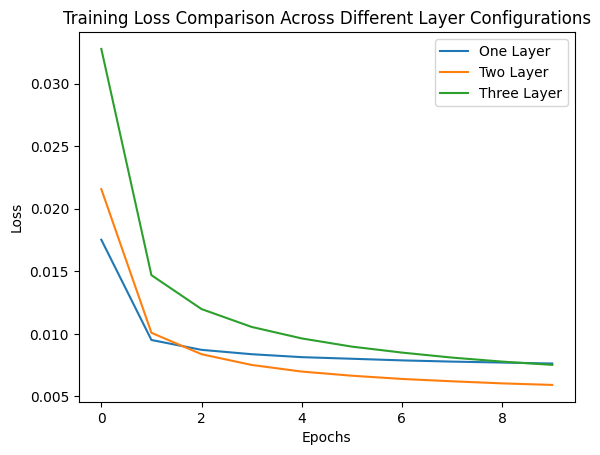

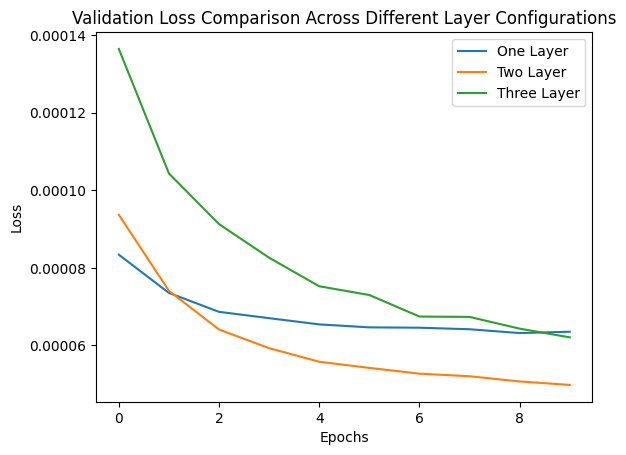

In [18]:
plt.plot(train_loss_1, label=f'One Layer')
plt.plot(train_loss_2, label=f'Two Layer')
plt.plot(train_loss_3, label=f'Three Layer')
plt.title('Training Loss Comparison Across Different Layer Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.figure(10, 8)
plt.plot(val_loss_1, label=f'One Layer')
plt.plot(val_loss_2, label=f'Two Layer')
plt.plot(val_loss_3, label=f'Three Layer')
plt.title('Validation Loss Comparison Across Different Layer Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

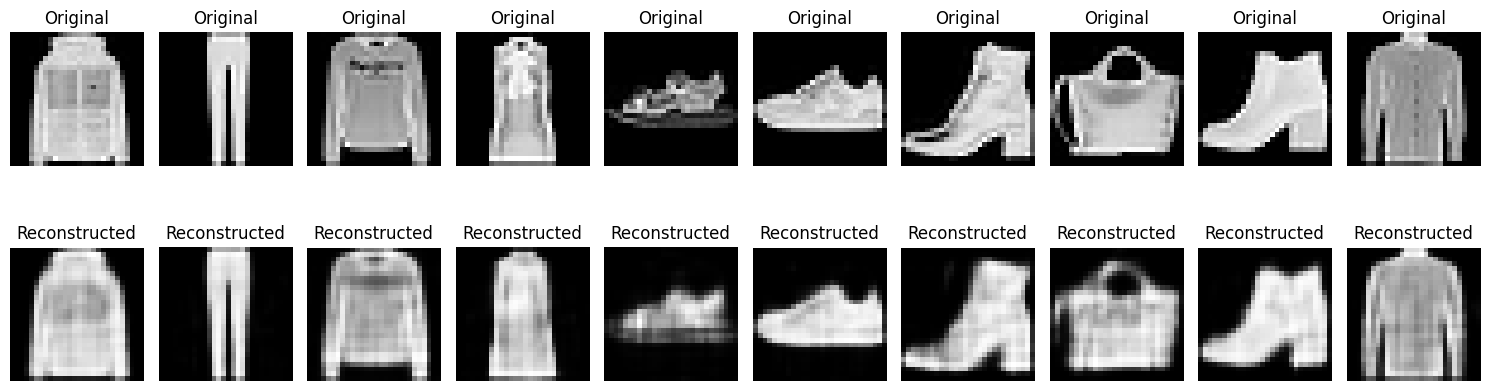

In [19]:
visualize_reconstructions(model_1_layers, test_loader, num_images=10)


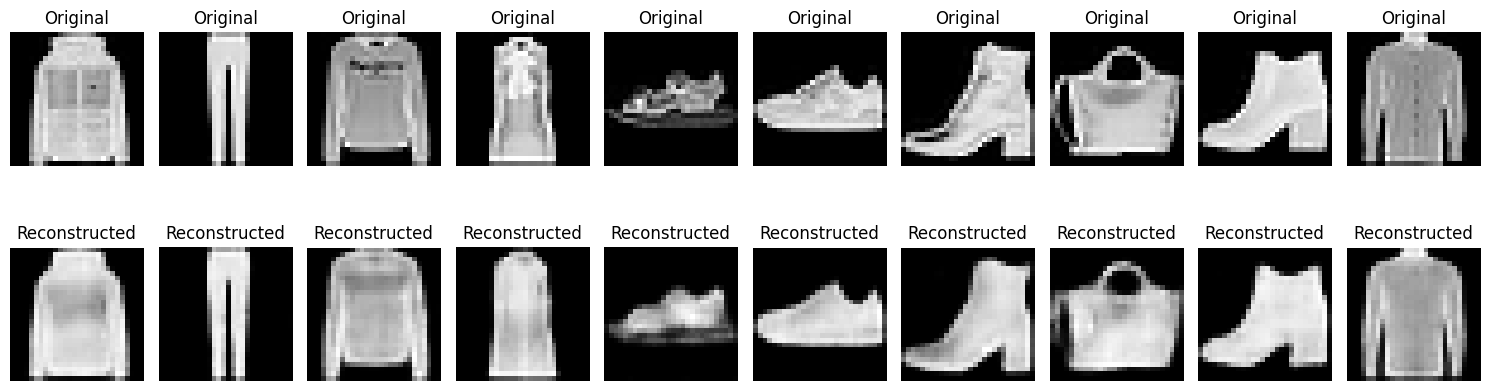

In [20]:
visualize_reconstructions(model_2_layers, test_loader, num_images=10)


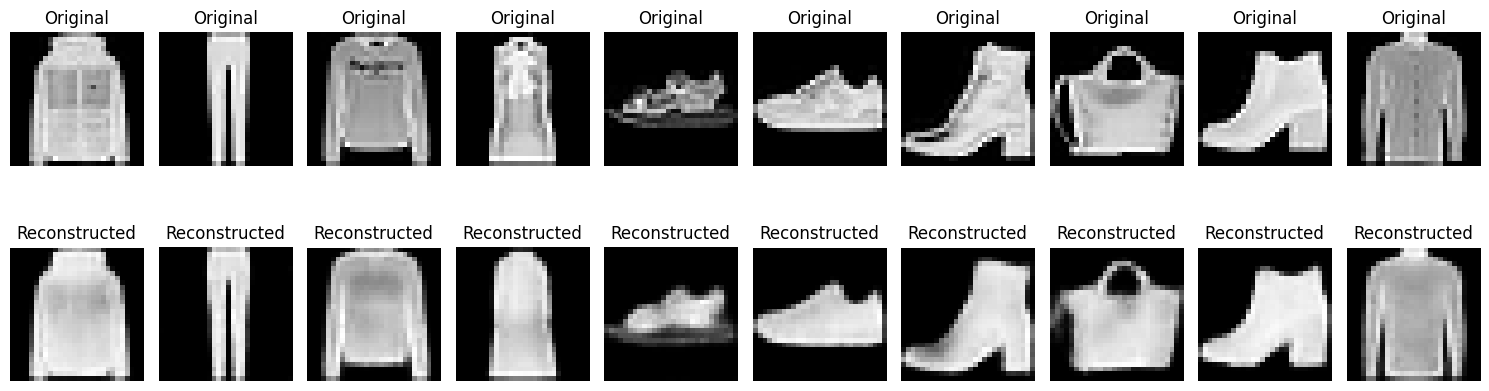

In [21]:
visualize_reconstructions(model_3_layers, test_loader, num_images=10)

## MLP

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)
class MLPRegression():
    def __init__(self, layers, activation='relu', learning_rate=0.01, optimizer='sgd', epochs=100, early_stopping=False, batch_size = 32, wandb_log = False, print_cost_interval = None, random_state = None):
        if random_state:     
            np.random.seed(random_state)
        
        self.layers = layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.weights = self._init_weights()
        self.biases = self._init_biases()
        self.loss_history = []

        self.wandb_log = wandb_log
        self.print_cost_interval = print_cost_interval

        # For early stopping
        self.early_stopping = early_stopping
        self.patience = 10
        self.patience_counter = 0
        self.best_cost = np.inf

        self.activation_functions = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            
        }
    
    def _init_weights(self):
        weights = []
        for i in range(len(self.layers) - 1):
            weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2/self.layers[i]))
        return weights
    
    def _init_biases(self):
        return [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]
    
    def forward_propagation(self,X):
        activations = [X]
        zs = []

        # Hidden layers can use any activation function
        for i in range(len(self.weights)-1):
            W = self.weights[i]
            b = self.biases[i]
            z = np.dot(activations[-1],W) + b
            zs.append(z)
            A = self.activation_functions[self.activation][0](z)
            activations.append(A)

        # Output layer uses softmax activation function if multiclass otherwise sigmoid
        W = self.weights[-1]
        b = self.biases[-1]
        z = np.dot(activations[-1],W) + b
        zs.append(z)
        A  = z
        activations.append(A)
        return activations, zs
    
    def backpropagation(self, activations, zs, y, X):
        dW = [np.zeros(w.shape) for w in self.weights]
        db = [np.zeros(b.shape) for b in self.biases]

        delta = (activations[-1] - y)
        db[-1] = np.sum(delta, axis=0, keepdims=True) 
        dW[-1] = np.dot(activations[-2].T,delta)

        for i in range(len(self.weights)-2, -1, -1):
            delta = np.dot(delta, self.weights[i+1].T) * self.activation_functions[self.activation][1](zs[i])
            activations[i] = activations[i].reshape(-1,self.layers[i])
            dW[i] = np.dot(activations[i].T, delta)
            db[i] = np.sum(delta, axis=0, keepdims=True)

        return dW,db

    def update_parameters(self, dW, db):
        for i in range(len(self.weights)):      
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
    
    def fit(self,X_train, y_train, X_val,y_val):
        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                self._sgd(X_train, y_train)
            elif self.optimizer == 'batch_gd':
                self._batch_gd(X_train, y_train)
            elif self.optimizer == 'mini_batch_gd':
                self._mini_batch_gd(X_train, y_train)
            
            # Compute cost after every epoch
            cost_train = self._cost(X_train, y_train)
            self.loss_history.append(cost_train)

            if X_val is not None and y_val is not None:
                val_cost = self._cost(X_val, y_val)

           # If early stopping is enabled, check the validation cost
            if self.early_stopping and X_val is not None and y_val is not None:
                # Check if validation cost has improved
                if val_cost < self.best_cost:
                    self.best_cost = val_cost
                    self.patience_counter = 0
                else:
                    self.patience_counter += 1
                
                # If patience is exhausted, stop training
                if self.patience_counter >= self.patience:
                    print(f'Early stopping at epoch {epoch}')
                    break
            
            if self.wandb_log:
                data_to_wandb = {
                    "epoch": epoch+1,
                    "val_loss": val_cost,
                    "train_loss": cost_train
                }
                wandb.log(data_to_wandb)
            
            print(f"Cost at epoch {epoch}: {cost_train}")
                # print(f"Validation cost at epoch {epoch}: {val_cost}")
            
        return self.loss_history
    
    def _sgd(self, X, y):
        for i in range(X.shape[0]):
            X_sample = X[i]
            y_sample = y[i]
            activations, zs = self.forward_propagation(X_sample)
            dW, db = self.backpropagation(activations, zs, y_sample, X)
            self.update_parameters(dW, db)

    def _batch_gd(self, X, y):
        dW_final = [np.zeros(w.shape) for w in self.weights]
        db_final = [np.zeros(b.shape) for b in self.biases]

        for i in range(X.shape[0]):
            X_sample = X[i]
            y_sample = y[i]
            activations, zs = self.forward_propagation(X_sample)
            dW, db = self.backpropagation(activations, zs, y_sample, X)

            for j in range(len(self.weights)):
                dW_final[j] += dW[j]
                db_final[j] += db[j]
        # Update taking the average of the gradients
        dW_final = [dW / X.shape[0] for dW in dW_final]

        db_final = [db / X.shape[0] for db in db_final]
        self.update_parameters(dW_final, db_final)

    def _mini_batch_gd(self, X, y):
        num_batches = X.shape[0] // self.batch_size
        for i in range(num_batches):
            dW_batch = [np.zeros(w.shape) for w in self.weights]
            db_batch = [np.zeros(b.shape) for b in self.biases]
            X_batch = X[i*self.batch_size:(i+1)*self.batch_size]
            y_batch = y[i*self.batch_size:(i+1)*self.batch_size]

            for j in range(X_batch.shape[0]):
                X_sample = X_batch[j]
                y_sample = y_batch[j]
                activations, zs = self.forward_propagation(X_sample)
                dW, db = self.backpropagation(activations, zs, y_sample, X)

                for k in range(len(self.weights)):
                    dW_batch[k] += dW[k]
                    db_batch[k] += db[k]
            # Update taking the average of the gradients    
            dW_batch = [dW / X_batch.shape[0] for dW in dW_batch]
            db_batch = [db / X_batch.shape[0] for db in db_batch]

            self.update_parameters(dW_batch, db_batch)

    def predict(self, X_test):
        activations, _ = self.forward_propagation(X_test)
        return activations[-1]
    
    def mse(self,y_true,y_pred):
        return 0.5*np.mean((y_true - y_pred)**2)

    def rmse(self,y_true,y_pred):
        return np.sqrt(np.mean((y_true - y_pred)**2))
    
    def mae(self,y_true,y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def r2(self,y_true,y_pred):
        return r2_score(y_true, y_pred)
    
    def _cost(self, X, y):
        activations= self.predict(X)
        mse = self.mse(y, activations)
        return mse
    
 

In [9]:
train_data = []
for images, _ in train_loader:
    flattened_images = images.view(images.size(0), -1).numpy()  # Flatten the 28x28 images
    train_data.append(flattened_images)
train_data = np.vstack(train_data)  # Combine all batches into a single array

val_data = []
for images, _ in val_loader:
    flattened_images = images.view(images.size(0), -1).numpy()  # Flatten the 28x28 images
    val_data.append(flattened_images)
val_data = np.vstack(val_data)  # Combine all batches into a single array

test_data = []
for images, _ in test_loader:
    flattened_images = images.view(images.size(0), -1).numpy()  # Flatten the 28x28 images
    test_data.append(flattened_images)
test_data = np.vstack(test_data) 

In [10]:
class AutoEncoder:
    def __init__(self, input_size, latent_dim, hidden_layers=[10], learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd'):
        # Constructing layers for encoder-decoder structure
        self.layers = [input_size] + hidden_layers + [latent_dim] + hidden_layers[::-1] + [input_size]
        
        self.encoder = MLPRegression(
            layers=self.layers,
            activation='sigmoid',
            learning_rate=learning_rate,
            optimizer=optimizer,
            epochs=epochs,
            batch_size=batch_size
        )
    
    def fit(self, X):
        # Train the encoder
        self.encoder.fit(X, X, None, None)
         
    def get_latent(self, X):
        # Retrieve the latent representation (middle layer output)
        latent_representation, _ = self.encoder.forward_propagation(X)
        l_i = len(self.layers) // 2
        return latent_representation[l_i]

    def reconstruct(self, X):
        # Reconstruct by passing X through the autoencoder
        return self.encoder.predict(X)

# Training and utility functions
def train_mlp_autoencoder(model, X_train, X_val=None, epochs=51):
    train_losses = []
    val_losses = []
    
    # Train the model
    model.fit(X_train)
    
    # Training loss history
    train_losses = model.encoder.loss_history
    
    # Compute validation loss if validation data is provided
    if X_val is not None:
        for epoch in range(epochs):
            val_pred = model.reconstruct(X_val)
            val_loss = np.mean((val_pred - X_val) ** 2)
            val_losses.append(val_loss)
            
    
    return train_losses, val_losses

# Visualization functions
def plot_loss_curves(train_losses, val_losses=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MLP Autoencoder Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def visualize_reconstructions_mlp(model, X_test, num_images=10):
    reconstructed = model.reconstruct(X_test[:num_images])
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Reconstructed images
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Cost at epoch 0: 0.011107193426683882
Cost at epoch 1: 0.009378129311847297
Cost at epoch 2: 0.008771490043745254
Cost at epoch 3: 0.008481772904161472
Cost at epoch 4: 0.007995486244939632
Cost at epoch 5: 0.007562065718424662
Cost at epoch 6: 0.007333330439143769
Cost at epoch 7: 0.007172508597340629
Cost at epoch 8: 0.0070953758330609615
Cost at epoch 9: 0.007068738056082049
Cost at epoch 10: 0.007032901616721931
Cost at epoch 11: 0.0069010481874003425
Cost at epoch 12: 0.006848167575531292
Cost at epoch 13: 0.006847059460749253
Cost at epoch 14: 0.006838617388399886
Cost at epoch 15: 0.006831492486511348
Cost at epoch 16: 0.0068294494421061525
Cost at epoch 17: 0.006837974617817462
Cost at epoch 18: 0.0068590596286605895
Cost at epoch 19: 0.006887414466632732
Cost at epoch 20: 0.006913255420879083
Cost at epoch 21: 0.006928075995577846
Cost at epoch 22: 0.006928892560866662
Cost at epoch 23: 0.006917566969592689
Cost at epoch 24: 0.006897016007216105
Cost at epoch 25: 0.00687170390

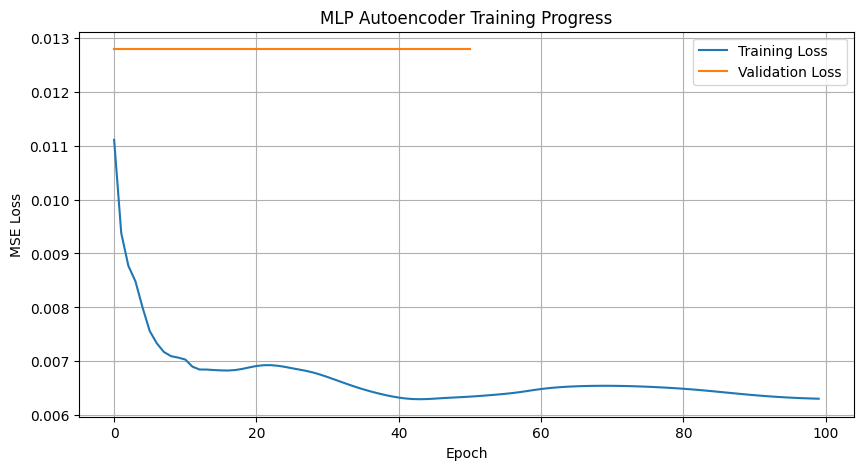

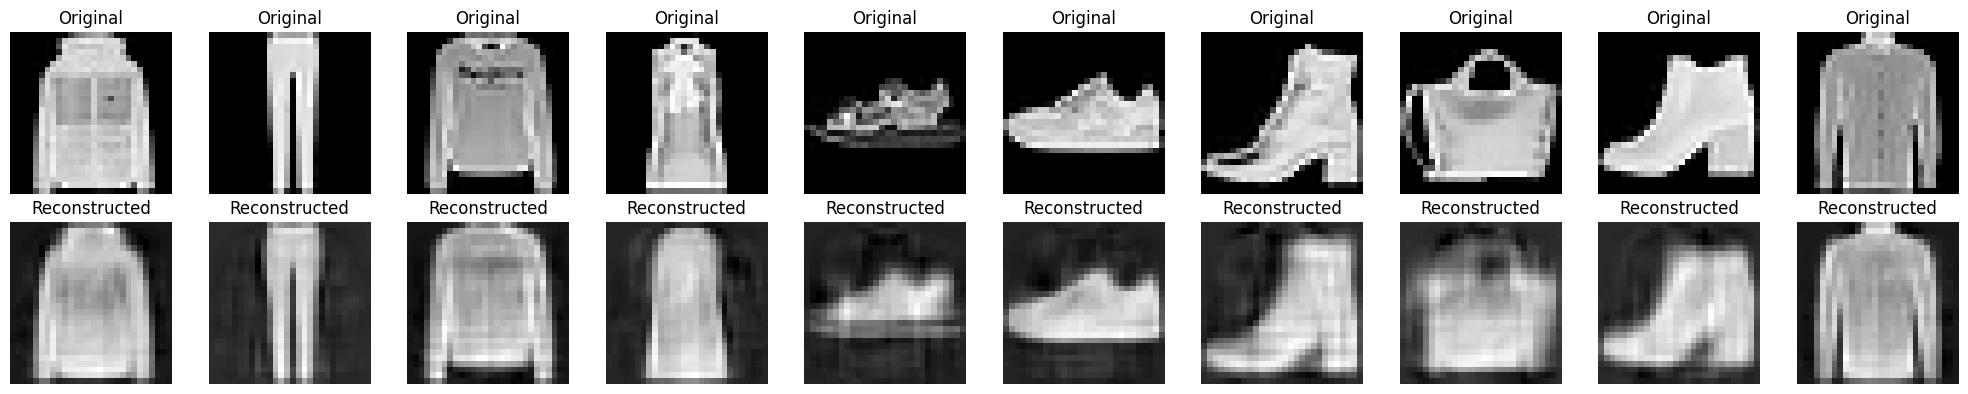


Reconstruction MSE:
Training set: 0.012613
Validation set: 0.012788
Test set: 0.012564


In [21]:
input_size = train_data.shape[1]
latent_size = 6
hidden_layers = [64]

mlp_autoencoder = AutoEncoder(
    input_size=input_size,
    latent_dim=latent_size,
    hidden_layers=hidden_layers,
    learning_rate=0.01,
    epochs=100,
)

# Train model and visualize results
train_losses, val_losses = train_mlp_autoencoder(mlp_autoencoder, train_data, val_data)
plot_loss_curves(train_losses, val_losses)

# Visualize reconstructions
visualize_reconstructions_mlp(mlp_autoencoder, test_data, num_images=10)

# Reconstruction quality comparison
train_recon = mlp_autoencoder.reconstruct(train_data)
val_recon = mlp_autoencoder.reconstruct(val_data)
test_recon = mlp_autoencoder.reconstruct(test_data)

print("\nReconstruction MSE:")
print(f"Training set: {np.mean((train_recon - train_data) ** 2):.6f}")
print(f"Validation set: {np.mean((val_recon - val_data) ** 2):.6f}")
print(f"Test set: {np.mean((test_recon - test_data) ** 2):.6f}")


CNN: 

Train Reconstruction Error: 0.007374

Validation Reconstruction Error: 0.008781

Test Reconstruction Error: 0.006541

In [11]:
# import sys
# import os

# # Get the absolute path to the project root and add it to sys.path
# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "../../"))
# sys.path.append(project_root)

import numpy as np
# from models.pca.pca import PCA

class PCA:
    def __init__(self, n_components=2):
        # Initialise the PCA Class
        
        """
        Parameters:
            n_components: Number of principal components to keep
        """
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None
        
    def fit(self, X):
        # Fits the PCA model to the data
        # X: Input data
        
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Calculate the covariance matrix
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        # Perform eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Sort eigenvectors in descending order of eigenvalues
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select the top n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]
        
        self.explained_variance = eigenvalues[:self.n_components]
        
    def transform(self,X):
        # Transforms the input data into the reduced dimension space
        
        # Center the data
        X_centered = X - self.mean
        
        # Project the data onto the principal components
        X_transformed = np.dot(X_centered, self.components)
        
        return X_transformed
    
    def checkPCA(self, X):
        # Check if PCA class reduces the dimensions appropriately
        X_transformed = self.transform(X)
        X_recieved = self.inverse_transform(X_transformed)
        # print(X[0][:10])
        # print(X_recieved[0][:10])        
        return np.allclose(X, X_recieved, atol=1.1, equal_nan=False)
    
    def inverse_transform(self, X_transformed):
        # Transform the reduced dimension data back to the original spac
        return np.dot(X_transformed, self.components.T) + self.mean

class PcaAutoencoder:
    def __init__(self, n_components=2):
        self.pca = PCA(n_components=n_components)
        
    def fit(self, X):
        self.pca.fit(X)
        
    def encode(self, X):
        return self.pca.transform(X)
    
    def decode(self, X_encoded):
        return self.pca.inverse_transform(X_encoded)
    
    def forward(self, X):
        X_encoded = self.encode(X)
        X_reconstructed = self.decode(X_encoded)
        return X_reconstructed

In [12]:
from sklearn.metrics import mean_squared_error

def estimate_optimal_components(X_train, X_val, max_components=30):
    errors = []

    # Iterate through different numbers of components
    for n_components in range(1, max_components + 1):
        # Initialize and fit PCA autoencoder
        pca_autoencoder = PcaAutoencoder(n_components=n_components)
        pca_autoencoder.fit(X_train)
        
        # Reconstruct the validation data
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        
        # Calculate reconstruction error (MSE)
        mse = mean_squared_error(X_val, X_val_reconstructed)
        errors.append(mse)
        
        print(f"Components: {n_components}, MSE: {mse}")

    # Plot the elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_components + 1), errors, marker='o', linestyle='-')
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot for PCA Autoencoder")
    plt.show()
    
def visualize_reconstructions_pca(X_test, koptimal, n_images=10):
    # Initialize PCA autoencoder with koptimal components
    pca_autoencoder = PcaAutoencoder(n_components=koptimal)
    pca_autoencoder.fit(X_test)  # Ideally fit on the training set, but for visualization, we use test set here

    # Get original and reconstructed images
    X_test_encoded = pca_autoencoder.encode(X_test)
    X_test_reconstructed = pca_autoencoder.decode(X_test_encoded)

    # Plot original and reconstructed images
    plt.figure(figsize=(15, 4))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title("Original")

        # Reconstructed image
        plt.subplot(2, n_images, i + n_images + 1)
        plt.imshow(X_test_reconstructed[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        plt.title("Reconstructed")

    plt.suptitle(f"Reconstructions with koptimal = {koptimal}")
    plt.tight_layout()
    plt.show()

In [13]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Validation dataset shape: {val_data.shape}")

Train dataset shape: (42000, 784)
Validation dataset shape: (5999, 784)


Components: 1, MSE: 0.06177489819904603
Components: 2, MSE: 0.046430739883264294
Components: 3, MSE: 0.04119666915016059
Components: 4, MSE: 0.03697331655323129
Components: 5, MSE: 0.03368324646879688
Components: 6, MSE: 0.030652637499706214
Components: 7, MSE: 0.028587995066219573
Components: 8, MSE: 0.026932949418132922
Components: 9, MSE: 0.02578037024941569
Components: 10, MSE: 0.024622602064521625
Components: 11, MSE: 0.02373325592030901
Components: 12, MSE: 0.022934573361697363
Components: 13, MSE: 0.02225805421955656
Components: 14, MSE: 0.021659508792349187
Components: 15, MSE: 0.02113116829260961
Components: 16, MSE: 0.02062204873707696
Components: 17, MSE: 0.020143784563610954
Components: 18, MSE: 0.01967230775151984
Components: 19, MSE: 0.019271400520672298
Components: 20, MSE: 0.01887088466363891
Components: 21, MSE: 0.018493377440001242
Components: 22, MSE: 0.018141475029872584
Components: 23, MSE: 0.017801175815477056
Components: 24, MSE: 0.017481654482925466
Components: 

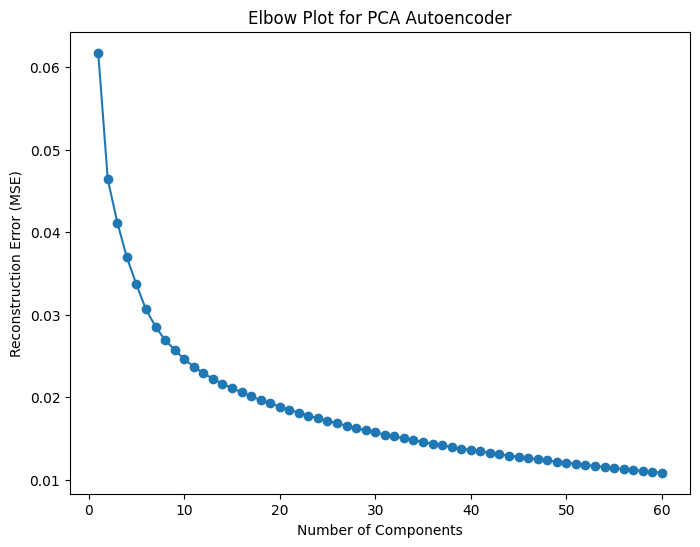

In [17]:
estimate_optimal_components(train_data, val_data, max_components=60)

Optimal number of components: 8


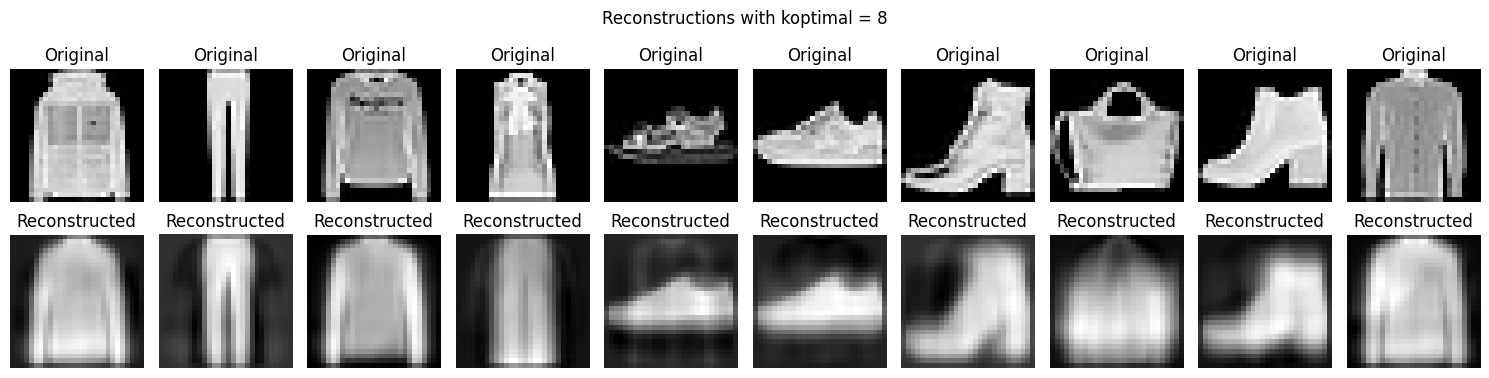

In [18]:
koptimal = 8
print(f"Optimal number of components: {koptimal}")

# Visualize the reconstructed images
visualize_reconstructions_pca(test_data, koptimal)

In [20]:
pca_autoencoder = PcaAutoencoder(n_components=koptimal)
pca_autoencoder.fit(train_data)

# Reconstruct the trian, val, test data
train_data_reconstructed = pca_autoencoder.forward(train_data)
val_data_reconstructed = pca_autoencoder.forward(val_data)
test_data_reconstructed = pca_autoencoder.forward(test_data)

train_reconstruction_error = ((train_data - train_data_reconstructed) ** 2).mean()
val_reconstruction_error = ((val_data - val_data_reconstructed) ** 2).mean()
test_reconstruction_error = ((test_data - test_data_reconstructed) ** 2).mean()
# Print comparison metrics
print("\nReconstruction MSE:")
print(f"Training set: {train_reconstruction_error:.6f}")
print(f"Validation set: {val_reconstruction_error:.6f}")
print(f"Test set: {test_reconstruction_error:.6f}")


Reconstruction MSE:
Training set: 0.026703
Validation set: 0.026933
Test set: 0.026413


## KNN

In [14]:
best_model_parameters = {
    'filters': [32, 64, 128],
    'kernel_size': 7,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'num_epochs': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_autoencoder = CnnAutoencoder(latent_dim=8, kernel=best_model_parameters['kernel_size'], filters=best_model_parameters['filters']).to(device)

cnn_autoencoder.train_autoencoder(train_loader, val_loader, num_epochs=best_model_parameters['num_epochs'], learning_rate=best_model_parameters['learning_rate'], optimizer_choice=best_model_parameters['optimizer'])

latent_features_cnn_train, _ = collect_latent_representations(cnn_autoencoder, train_loader)
latent_features_cnn_test, _ = collect_latent_representations(cnn_autoencoder, test_loader)

images, _ = next(iter(train_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
train_reconstruction_error = ((images - reconstructed) ** 2).mean().item()
images, _ = next(iter(val_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
val_reconstruction_error = ((images - reconstructed) ** 2).mean().item()
images, _ = next(iter(test_loader))
images = images.to(device)
reconstructed = cnn_autoencoder(images)
test_reconstruction_error = ((images - reconstructed) ** 2).mean().item()

print(f"Train Reconstruction Error: {train_reconstruction_error:.6f}")
print(f"Validation Reconstruction Error: {val_reconstruction_error:.6f}")
print(f"Test Reconstruction Error: {test_reconstruction_error:.6f}")

Epoch [1/10], Train Loss: 0.0269
Epoch [1/10], Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0164
Epoch [2/10], Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0150
Epoch [3/10], Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0142
Epoch [4/10], Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0137
Epoch [5/10], Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0134
Epoch [6/10], Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0131
Epoch [7/10], Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0129
Epoch [8/10], Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0127
Epoch [9/10], Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0126
Epoch [10/10], Val Loss: 0.0001
Train Reconstruction Error: 0.010708
Validation Reconstruction Error: 0.015485
Test Reconstruction Error: 0.012260


In [16]:
input_size = train_data.shape[1]
latent_size = 8
hidden_layers = [64]

mlp_autoencoder = AutoEncoder(
    input_size=input_size,
    latent_dim=latent_size,
    hidden_layers=hidden_layers,
    learning_rate=0.01,
    epochs=25,
)

train_losses, val_losses = train_mlp_autoencoder(mlp_autoencoder, train_data, val_data)
# plot_loss_curves(train_losses, val_losses)

# Reconstruction quality comparison
train_recon = mlp_autoencoder.reconstruct(train_data)
val_recon = mlp_autoencoder.reconstruct(val_data)
test_recon = mlp_autoencoder.reconstruct(test_data)

print("\nReconstruction MSE:")
print(f"Training set: {np.mean((train_recon - train_data) ** 2):.6f}")
print(f"Validation set: {np.mean((val_recon - val_data) ** 2):.6f}")
print(f"Test set: {np.mean((test_recon - test_data) ** 2):.6f}")


latent_features_mlp_train = mlp_autoencoder.get_latent(train_data)
latent_features_mlp_test = mlp_autoencoder.get_latent(test_data)

Cost at epoch 0: 0.013484004860161792
Cost at epoch 1: 0.012229348687745003
Cost at epoch 2: 0.01169746584848484
Cost at epoch 3: 0.01133968181467832
Cost at epoch 4: 0.01104390902491407
Cost at epoch 5: 0.010853043280375488
Cost at epoch 6: 0.010611948336179974
Cost at epoch 7: 0.010404243479212351
Cost at epoch 8: 0.010285572526970656
Cost at epoch 9: 0.010163136185294123
Cost at epoch 10: 0.01005029310480847
Cost at epoch 11: 0.009921115359103908
Cost at epoch 12: 0.009825900783722565
Cost at epoch 13: 0.009749540380069211
Cost at epoch 14: 0.009690892947982784
Cost at epoch 15: 0.009631148946798706
Cost at epoch 16: 0.009573857936781414
Cost at epoch 17: 0.009560920073266158
Cost at epoch 18: 0.009527997893943457
Cost at epoch 19: 0.009492989021247124
Cost at epoch 20: 0.009458503641657857
Cost at epoch 21: 0.00942240324539124
Cost at epoch 22: 0.00939714500464332
Cost at epoch 23: 0.009373647827697364
Cost at epoch 24: 0.009354066172663347

Reconstruction MSE:
Training set: 0.0187

In [17]:
koptimal = 8

pca_autoencoder = PcaAutoencoder(n_components=koptimal)
pca_autoencoder.fit(train_data)

# Reconstruct the trian, val, test data
train_data_reconstructed = pca_autoencoder.forward(train_data)
val_data_reconstructed = pca_autoencoder.forward(val_data)
test_data_reconstructed = pca_autoencoder.forward(test_data)

train_reconstruction_error = ((train_data - train_data_reconstructed) ** 2).mean()
val_reconstruction_error = ((val_data - val_data_reconstructed) ** 2).mean()
test_reconstruction_error = ((test_data - test_data_reconstructed) ** 2).mean()
# Print comparison metrics
print("\nReconstruction MSE:")
print(f"Training set: {train_reconstruction_error:.6f}")
print(f"Validation set: {val_reconstruction_error:.6f}")
print(f"Test set: {test_reconstruction_error:.6f}")


Reconstruction MSE:
Training set: 0.026703
Validation set: 0.026933
Test set: 0.026413


In [18]:
latent_features_pca_train = pca_autoencoder.encode(train_data)
latent_features_pca_test = pca_autoencoder.encode(test_data)

In [19]:
print(f"PCA Latent Features - Train: {latent_features_pca_train.shape}, Test: {latent_features_pca_test.shape}")
print(f"CNN Latent Features - Train: {latent_features_cnn_train.shape}, Test: {latent_features_cnn_test.shape}")
print(f"MLP Latent Features - Train: {latent_features_mlp_train.shape}, Test: {latent_features_mlp_test.shape}")

PCA Latent Features - Train: (42000, 8), Test: (12001, 8)
CNN Latent Features - Train: (42000, 8), Test: (12001, 8)
MLP Latent Features - Train: (42000, 8), Test: (12001, 8)


In [20]:
k_neighbours = 5

import numpy as np
import time


class KNN:
    def __init__(self, k=3, distance_metric="manhattan", optimization_type="optimized"):
        self.k = k
        self.distance_metric = distance_metric
        self.optimization_type = optimization_type

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        start_time = time.time()
        if X.ndim == 1:
            X = X.reshape(1, -1)
        predictions = [self._predict(x) for x in X]
        end_time = time.time()
        inference_time = end_time - start_time

        return {"predictions": np.array(predictions), "inference_time": inference_time}

    def _predict(self, x):
        if self.optimization_type != "optimized":
            distances = self._compute_distances_naive(x)
        else:
            distances = self._compute_distances(x)
        k_indices = np.argsort(distances)[: self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return self._most_common_label(k_nearest_labels)

    def _compute_distances(self, x):
        if self.distance_metric == "euclidean":
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            return distances
        elif self.distance_metric == "manhattan":
            return np.sum(np.abs(self.X_train - x), axis=1)
        elif self.distance_metric == "cosine":
            dot_product = np.dot(self.X_train, x)
            x_norm = np.linalg.norm(x)
            X_train_norm = np.linalg.norm(self.X_train, axis=1)
            cosine_similarity = dot_product / (x_norm * X_train_norm)
            cosine_distance = 1 - cosine_similarity
            return cosine_distance
        else:
            raise ValueError("Unsupported distance metric")

    def _compute_distances_naive(self, x):
        distances = []
        for train_x in self.X_train:
            if self.distance_metric == "euclidean":
                squared_sum = 0
                for i in range(len(train_x)):
                    squared_sum += (train_x[i] - x[i]) ** 2
                distance = squared_sum**0.5  # equivalent to np.sqrt(squared_sum)

            elif self.distance_metric == "manhattan":
                abs_sum = 0
                for i in range(len(train_x)):
                    abs_sum += abs(
                        train_x[i] - x[i]
                    )  # equivalent to np.sum(np.abs(train_x - x))
                distance = abs_sum

            elif self.distance_metric == "cosine":
                dot_product = 0
                train_x_norm = 0
                x_norm = 0
                for i in range(len(train_x)):
                    dot_product += train_x[i] * x[i]
                    train_x_norm += train_x[i] ** 2
                    x_norm += x[i] ** 2
                cosine_similarity = dot_product / ((train_x_norm**0.5) * (x_norm**0.5))
                distance = 1 - cosine_similarity

            else:
                raise ValueError("Unsupported distance metric")

            distances.append(distance)

        return distances

    def _most_common_label(self, labels):
        values, counts = np.unique(labels, return_counts=True)
        return values[np.argmax(counts)]

from sklearn.metrics import accuracy_score

def knn_classification(knn, X_train_latent, y_train, X_test_latent, y_test):
    knn.fit(X_train_latent, y_train)
    print("KNN for Train...")
    train_preds = knn.predict(X_train_latent)
    train_preds = train_preds["predictions"]
    
    print("KNN for Test...")
    test_preds = knn.predict(X_test_latent)
    test_preds = test_preds["predictions"]
    # train_accuracy = accuracy_score(y_train, train_preds)
    # test_accuracy = accuracy_score(y_test, test_preds)
    train_accuracy = np.sum(y_train == train_preds)/len(y_train)
    test_accuracy = np.sum(y_test == test_preds)/len(y_test)
    return train_accuracy, test_accuracy, test_preds

knn = KNN(k=24)

In [21]:
def infer_single_image(knn, image, label=None):
    # Reshape the image if needed (e.g., for flattened arrays)
    image = image.reshape(1, -1)
    
    # Make prediction for the single image
    result = knn.predict(image)
    predicted_label = result["predictions"][0]
    inference_time = result["inference_time"]
    
    # Print actual and predicted label
    if label is not None:
        print(f"Actual label: {label}")
    print(f"Predicted label: {predicted_label}")
    print(f"Inference time: {inference_time:.4f} seconds")
    
    return predicted_label

# Assuming X_test_latent is a flattened array of test images and y_test is the actual label array
# Choose an index to infer a specific image, for example, index 0
# index = 10
# infer_single_image(knn, latent_features_pca_test[index], test_labels[index])
# test_preds = knn.predict(latent_features_pca_test[:10])
# print(test_preds)
# print(test_labels[:10])
# print(test_preds==test_labels)

In [22]:
train_acc_pca, test_acc_pca, test_preds_pca = knn_classification(knn, latent_features_pca_train, train_labels, latent_features_pca_test, test_labels)


KNN for Train...
KNN for Test...


In [23]:
train_acc_mlp, test_acc_mlp, test_preds_mlp = knn_classification(knn, latent_features_mlp_train, train_labels, latent_features_mlp_test, test_labels)


KNN for Train...
KNN for Test...


In [24]:
train_acc_cnn, test_acc_cnn, test_preds_cnn = knn_classification(knn, latent_features_cnn_train, train_labels, latent_features_cnn_test, test_labels)


KNN for Train...
KNN for Test...


In [25]:
# Display the train and test accuracies for each model
print(f"PCA Autoencoder - Train Accuracy: {train_acc_pca * 100:.2f}%, Test Accuracy: {test_acc_pca * 100:.2f}%")
print(f"MLP Autoencoder - Train Accuracy: {train_acc_mlp * 100:.2f}%, Test Accuracy: {test_acc_mlp * 100:.2f}%")
print(f"CNN Autoencoder - Train Accuracy: {train_acc_cnn * 100:.2f}%, Test Accuracy: {test_acc_cnn * 100:.2f}%")

PCA Autoencoder - Train Accuracy: 21.18%, Test Accuracy: 9.74%
MLP Autoencoder - Train Accuracy: 20.85%, Test Accuracy: 10.16%
CNN Autoencoder - Train Accuracy: 21.15%, Test Accuracy: 9.16%


In [26]:
print(test_preds_cnn, test_labels)

[0 1 9 ... 7 5 6] [4 1 2 ... 1 2 7]


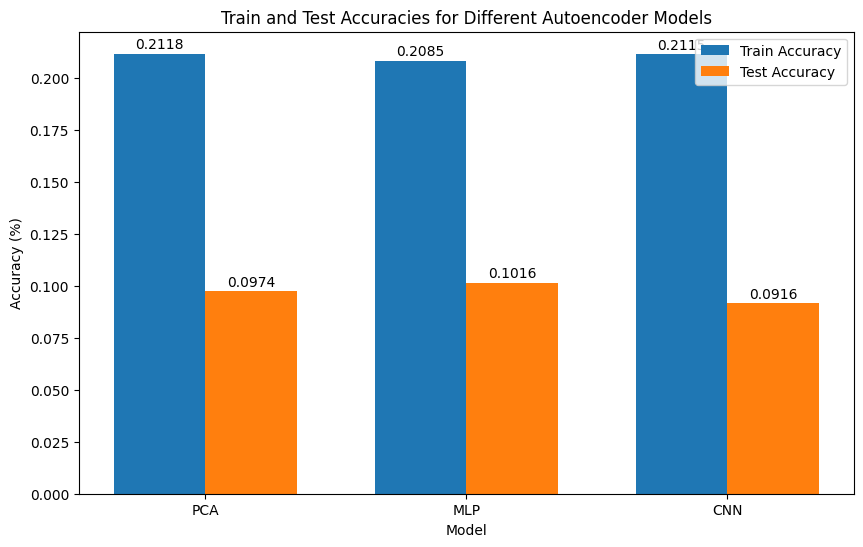

In [27]:
train_accuracies = [train_acc_pca, train_acc_mlp, train_acc_cnn]
test_accuracies = [test_acc_pca, test_acc_mlp, test_acc_cnn]

# Model names
models = ['PCA', 'MLP', 'CNN']

# X-axis positions
x = np.arange(len(models))

# Bar width
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
test_bars = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Labels and titles
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Train and Test Accuracies for Different Autoencoder Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bar in train_bars + test_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom')
    
plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Normalize the latent features for KNN
scaler = StandardScaler()
X_train_pca_latent_norm = scaler.fit_transform(latent_features_pca_train)
X_test_pca_latent_norm = scaler.transform(latent_features_pca_test)

X_train_mlp_latent_norm = scaler.fit_transform(latent_features_mlp_train)
X_test_mlp_latent_norm = scaler.transform(latent_features_mlp_test)

X_train_cnn_latent_norm = scaler.fit_transform(latent_features_cnn_train)
X_test_cnn_latent_norm = scaler.transform(latent_features_cnn_test)

# Test different values of k
for k in [1, 3, 5, 7]:
    knn = KNN(k=k, distance_metric='euclidean')

    # PCA Autoencoder
    knn.fit(X_train_pca_latent_norm, train_labels)
    train_acc_pca = accuracy_score(train_labels, knn.predict(X_train_pca_latent_norm)["predictions"])
    test_acc_pca = accuracy_score(test_labels, knn.predict(X_test_pca_latent_norm)["predictions"])

    # MLP Autoencoder
    knn.fit(X_train_mlp_latent_norm, train_labels)
    train_acc_mlp = accuracy_score(train_labels, knn.predict(X_train_mlp_latent_norm)["predictions"])
    test_acc_mlp = accuracy_score(test_labels, knn.predict(X_test_mlp_latent_norm)["predictions"])

    # CNN Autoencoder
    knn.fit(X_train_cnn_latent_norm, train_labels)
    train_acc_cnn = accuracy_score(train_labels, knn.predict(X_train_cnn_latent_norm)["predictions"])
    test_acc_cnn = accuracy_score(test_labels, knn.predict(X_test_cnn_latent_norm)["predictions"])

    print(f"\nk={k}")
    print(f"PCA Autoencoder - Train Accuracy: {train_acc_pca * 100:.2f}%, Test Accuracy: {test_acc_pca * 100:.2f}%")
    print(f"MLP Autoencoder - Train Accuracy: {train_acc_mlp * 100:.2f}%, Test Accuracy: {test_acc_mlp * 100:.2f}%")
    print(f"CNN Autoencoder - Train Accuracy: {train_acc_cnn * 100:.2f}%, Test Accuracy: {test_acc_cnn * 100:.2f}%")



k=1
PCA Autoencoder - Train Accuracy: 99.97%, Test Accuracy: 10.01%
MLP Autoencoder - Train Accuracy: 99.97%, Test Accuracy: 9.82%
CNN Autoencoder - Train Accuracy: 99.97%, Test Accuracy: 9.77%


KeyboardInterrupt: 

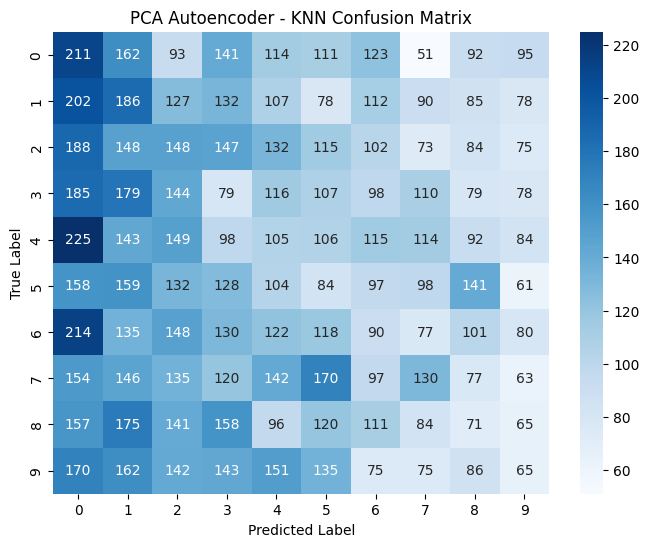

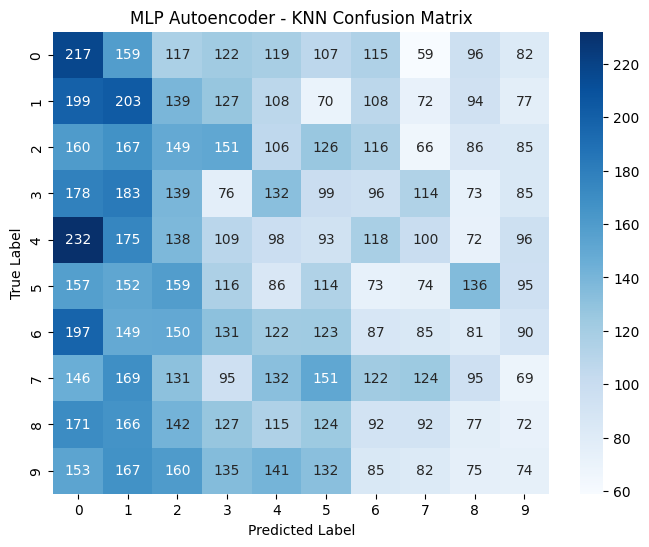

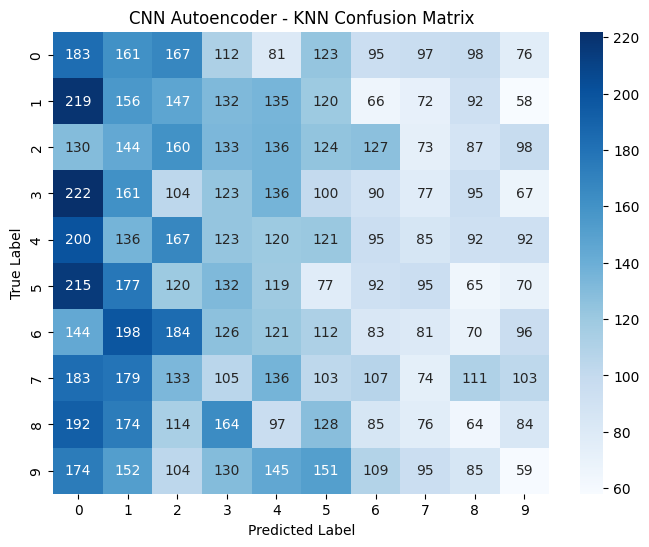

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
# Confusion matrices for each model
plot_confusion_matrix(test_labels, test_preds_pca, "PCA Autoencoder - KNN Confusion Matrix")
plot_confusion_matrix(test_labels, test_preds_mlp, "MLP Autoencoder - KNN Confusion Matrix")
plot_confusion_matrix(test_labels, test_preds_cnn, "CNN Autoencoder - KNN Confusion Matrix")

1. **Overall Performance Consistency:**
All three autoencoders (PCA, MLP, and CNN) show a similar pattern in their classification, with diagonal values (correct predictions) being dominant, which indicates that the models generally have high classification rates for certain classes but struggle with others.

2. **Classes with Consistent High Performance:**
Classes such as 1 and 7 appear to have relatively high values along the diagonal across all three autoencoders, suggesting that these classes are easier to classify correctly regardless of the autoencoder type. This could be due to distinct features in the data for these classes that make them more separable.

3. **Classes with Consistent Low Performance:**
Certain classes like 4, 8, and 9 have lower values on the diagonal across all three models, indicating that these classes are challenging to distinguish. This could be due to these classes having similar features or overlaps in the latent space representation, leading to higher misclassification rates.

4. **Misclassifications and Confusions:**
For some classes, there are consistent confusions across all three autoencoders. For example, there is a trend where classes 4 and 9 are confused with each other. This may suggest that the latent representations of these classes are close or that KNN struggles to differentiate them even after dimensionality reduction.

5. **Autoencoder Performance Comparison:**
Based on the confusion matrices, the CNN autoencoder tends to have slightly more concentrated diagonal values than the PCA and MLP autoencoders, suggesting that CNN’s learned latent space might be more effective for classification with KNN. However, the difference is not substantial, and overall accuracies (as noted before) are quite low for all models, which limits their effectiveness.

**<u>Analysis</u>:**
- **Feature Separation:** The consistent misclassification across classes for all three autoencoders suggests that the learned features might not be sufficiently separated for effective KNN classification.
- **Fine-Tuning:** For better results, fine-tuning hyperparameters of the autoencoders or trying additional layers for the MLP and CNN autoencoders may give a more distinct feature space.